In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# jax
import jax.numpy as jnp
import time

import sys
import os

path_ = os.path.abspath(os.path.join('..', '00_utils'))
if path_ not in sys.path:
    sys.path.append(path_)

path_ = os.path.abspath(os.path.join('..', '00_models'))
if path_ not in sys.path:
    sys.path.append(path_)
    
path_ = os.path.abspath(os.path.join('..', '00_utils_training'))
if path_ not in sys.path:
    sys.path.append(path_)

In [16]:
import importlib

def reload_module(module_name, class_name):
    module = importlib.import_module(module_name)
    importlib.reload(module)
    return getattr(module, class_name)

In [17]:
from datetime import datetime, timedelta

start_date = '2015-01-10'
def generate_dates(start_date, sequence_len = 5, frequency = 2):
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    date_sequences = [start_date + timedelta(days=i*frequency) for i in range(sequence_len)]
    date_sequences_str = [date.strftime('%Y-%m-%d') for date in date_sequences]
    return date_sequences_str

---
# Single Model

In [91]:
ExperimentRunner = reload_module('optimize_pyomo_rl', 'ExperimentRunner')

tol = 1e-6
start_date = '2015-01-10'
extra_input = {}
extra_input['params_data'] = {'file_path': '../00_data/df_train.csv', 'start_date': start_date, 
                'n_points': 600, 'split': 360, 'n_days': 1, 'm': 0, 
                'prev_hour': True, 'prev_week': True, 'prev_year': False,
                'spacing': 'gauss_radau',
                'encoding': {'settlement_date': 't', 'temperature': 'var1', 'hour': 'var2', 'nd': 'y'},}

extra_input['params_sequence'] = {'sequence_len': 1, 'frequency': 0}
extra_input['params_model'] = {'layer_sizes': [6, 32, 1], 'penalty': 1e-5}
extra_input['params_solver'] = { "tol" : tol, 
                         #"dual_inf_tol": tol, "compl_inf_tol": tol, "constr_viol_tol": tol, 
                         #"bound_relax_factor": 0.0001, 
                         "acceptable_constr_viol_tol": 1e-15, "acceptable_dual_inf_tol": 1e-15, "acceptable_compl_inf_tol": 1e-15, 
                         "halt_on_ampl_error" : 'yes', "print_level": 1, "max_iter": 500, 'warm_start_init_point': 'yes'}

extra_input['plot_odeint'] = True
extra_input['convergence_step'] = 5
extra_input['param_combinations'] = [1e-5, 1e-4, 1e-3]

runner = ExperimentRunner(start_date, 'regularization', extra_input)
runner.run()

Generating default parameters for ode solver
Running iteration 1 with parameters: 1e-05
current_16_08
y
Ipopt 3.14.16: tol=1e-06
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
halt_on_ampl_error=yes
print_level=1
max_iter=500
warm_start_init_point=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Ipopt 3.14.16: print_level=1


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://g

In [103]:
single_model_results = runner.results_full
df_single = pd.DataFrame(single_model_results).T
df_single.reset_index(inplace=True)
df_single.rename(columns={'level_0': 'regularization'}, inplace=True)
df_single.drop(columns=['level_1', 'result', 'mse_odeint', 'mse_odeint_test'], inplace=True)
df_single

,regularization,times_elapsed,mse_coll_ode,mse_coll_ode_test
0,0.00001,16.339293,0.03611,0.155286
1,0.00010,11.288714,0.050668,0.041353
2,0.00100,6.05034,0.285621,0.295455


[1e-05, 0.0001, 0.001]

---
# ADMM

In [55]:
# Constants and Configurations
PENALTY = 1e-3
LAYER_SIZES = [6, 32, 1]
tol = 1e-4
params = {
    "tol": tol,
    "dual_inf_tol": tol,
    "compl_inf_tol": tol,
    "constr_viol_tol": tol,
    "halt_on_ampl_error": 'yes',
    "print_level": 5,
    "max_iter": 500
}
file_path = '../00_data/df_train.csv'
encoding = {'settlement_date': 't', 'temperature': 'var1', 'hour': 'var2', 'nd': 'y'}

date_sequences_str = generate_dates(start_date, sequence_len = 1, frequency = 5)

def prepare_data(start_date, file_path, encoding):
    data_preprocessor = reload_module('preprocess', 'DataPreprocessor')(
        file_path, start_date=start_date, number_of_points = 360, n_days = 1, m = 0, 
        prev_hour = True, prev_week = True, prev_year = False,
        feature_encoding=encoding, split=180, spacing = 'gauss_radau', smooth = False
        )
    data_subsample = data_preprocessor.load_data()
    return data_preprocessor.preprocess_data(data_subsample), str(data_preprocessor.end_date), data_preprocessor.derivative_matrix()

In [115]:
DataPreprocessor = reload_module('preprocess', 'DataPreprocessor')
NeuralODEPyomoADMM = reload_module('nn_pyomo_admm', 'NeuralODEPyomoADMM')

results = {}
for start_date in date_sequences_str:
    (df_train_1, df_test_1), end_date, (D_1, _) = prepare_data(start_date, file_path, encoding)
    (df_train_2, df_test_2), _, (D_2, D_2_test) = prepare_data(end_date, file_path, encoding)

    # dhift time
    shift = df_train_2['t'].max() - df_train_2['t'].min()
    df_train_2['t'] += shift
    df_test_2['t'] += shift

    # concatenate data
    ys = np.concatenate([df_train_1['y'].values[:, None], df_train_2['y'].values[:, None]], axis = 0)
    ts = np.concatenate([df_train_1['t'], df_train_2['t']])
    Xs = np.concatenate([df_train_1.drop(columns=['y', 't']).values, df_train_2.drop(columns=['y', 't']).values], axis=0)
    Ds = [D_1, D_2]

    # Model and solve
    ode_model = NeuralODEPyomoADMM(
        y_observed=ys, t=ts, first_derivative_matrix=Ds,
        extra_input=Xs, y_init=ys, layer_sizes=LAYER_SIZES,
        act_func="tanh", penalty_lambda_reg=PENALTY, rho=1.0,
        time_invariant=True, w_init_method='xavier', params=params,
        test_data = {'t': df_test_2['t'], 'y': df_test_2['y'], 'D': D_2_test, 'X': df_test_2.drop(columns=['y', 't']).values}
    )
    
    result = ode_model.admm_solve(iterations = 30, tol_primal=1e-2, record=True)
    results[start_date] = result

# prepare test data
t_test = df_test_2['t']
y_test = df_test_2['y']
X_test = df_test_2.drop(columns=['y', 't']).values

----------------------------------------------------------------------------------------------------
ADMM Iteration 1/30; 0
----------------------------------------------------------------------------------------------------
Ipopt 3.14.16: tol=0.0001
dual_inf_tol=0.0001
compl_inf_tol=0.0001
constr_viol_tol=0.0001
halt_on_ampl_error=yes
print_level=5
max_iter=500


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    78223
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.......

In [117]:
df = pd.DataFrame(results).T
df

,primal_residual,mae_collocation,mse_collocation,mae_diffrax,mse_diffrax,iter,time_elapsed,mse_collocation_test
2015-01-10,"[74.54706320664829, 74.54706324591764, 3.44044...",[],"[3.5553533921051383, 3.7507751926320783, 0.961...",[],"[280.34664385081953, 283.6940821989306, 493.61...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[6.047824144363403, 6.381760120391846, 6.95143...","[1.0691383358765816, 1.0691418480284294, 0.241..."


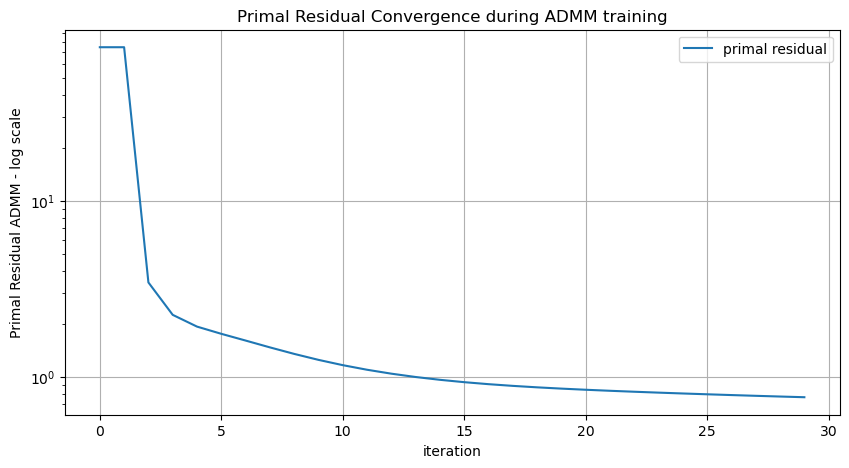

In [139]:
plt.figure(figsize=(10, 5))
plt.plot( df.iter.tolist()[0], df.primal_residual.tolist()[0], label='primal residual')
plt.xlabel('iteration')
plt.ylabel('Primal Residual ADMM - log scale')
plt.legend()
plt.grid()
plt.yscale('log') 
plt.title('Primal Residual Convergence during ADMM training')  
plt.show()

In [119]:
df_single

,regularization,times_elapsed,mse_coll_ode,mse_coll_ode_test
0,0.00001,16.339293,0.03611,0.155286
1,0.00010,11.288714,0.050668,0.041353
2,0.00100,6.05034,0.285621,0.295455


In [120]:
df

,primal_residual,mae_collocation,mse_collocation,mae_diffrax,mse_diffrax,iter,time_elapsed,mse_collocation_test
2015-01-10,"[74.54706320664829, 74.54706324591764, 3.44044...",[],"[3.5553533921051383, 3.7507751926320783, 0.961...",[],"[280.34664385081953, 283.6940821989306, 493.61...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[6.047824144363403, 6.381760120391846, 6.95143...","[1.0691383358765816, 1.0691418480284294, 0.241..."


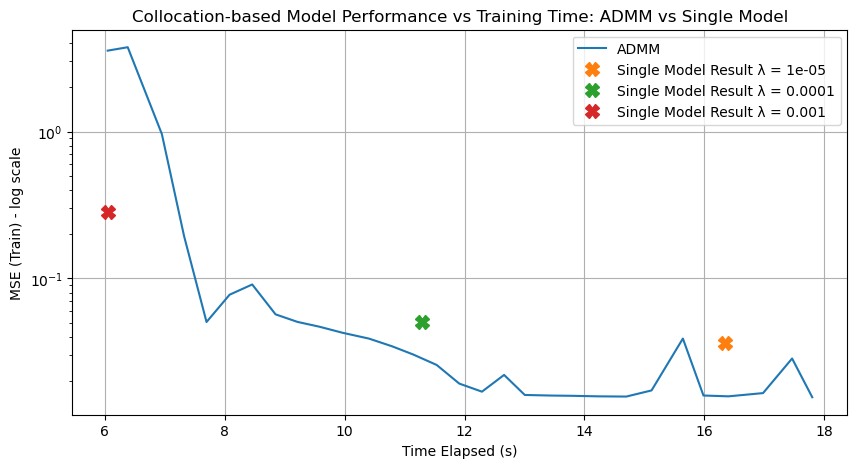

In [136]:
plt.figure(figsize=(10, 5))
plt.plot( df.time_elapsed.tolist()[0], df.mse_collocation.tolist()[0], label='ADMM')
#plt.scatter( df.time_elapsed.tolist()[0], df.mse_collocation.tolist()[0])
for i in range(df_single.shape[0]):
    plt.plot( df_single.times_elapsed.tolist()[i], df_single.mse_coll_ode.tolist()[i], 'X', markersize=10, label=f'Single Model Result λ = {df_single.regularization.tolist()[i]}')
plt.xlabel('Time Elapsed (s)')
plt.ylabel('MSE (Train) - log scale')
plt.yscale('log')
plt.title('Collocation-based Model Performance vs Training Time: ADMM vs Single Model')
plt.legend()
plt.grid()
plt.show()

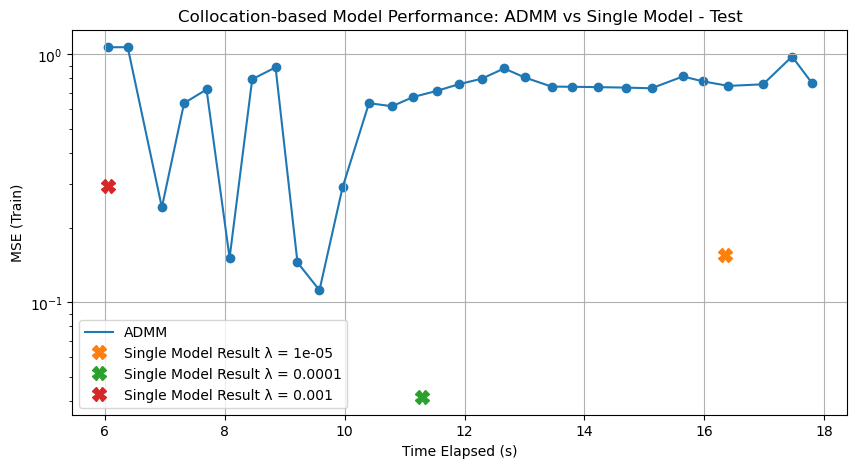

In [140]:
plt.figure(figsize=(10, 5))
plt.plot( df.time_elapsed.tolist()[0], df.mse_collocation_test.tolist()[0], label='ADMM')
plt.scatter( df.time_elapsed.tolist()[0], df.mse_collocation_test.tolist()[0])
for i in range(df_single.shape[0]):
    plt.plot( df_single.times_elapsed.tolist()[i], df_single.mse_coll_ode_test.tolist()[i], 'X', markersize=10, label=f'Single Model Result λ = {df_single.regularization.tolist()[i]}')
plt.xlabel('Time Elapsed (s)')
plt.ylabel('MSE (Train)')
plt.yscale('log')
plt.title('Collocation-based Model Performance: ADMM vs Single Model - Test')
plt.legend()
plt.grid()
plt.show()

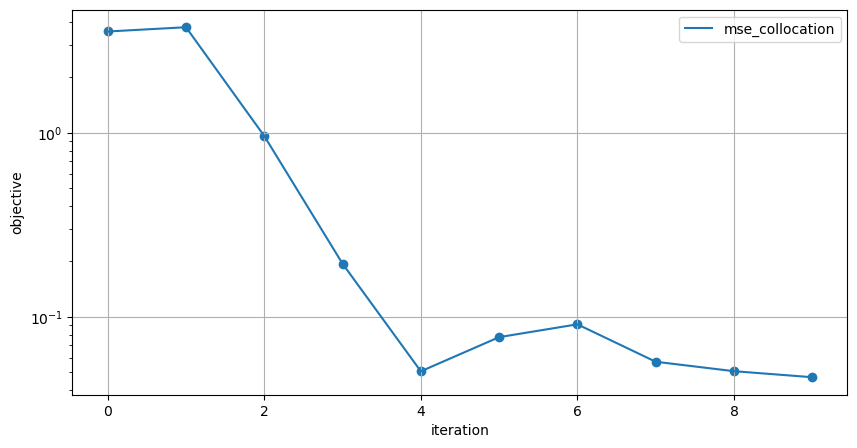

In [45]:
plt.figure(figsize=(10, 5))
plt.plot( df.iter.tolist()[0], df.mse_collocation.tolist()[0], label='mse_collocation')
plt.scatter( df.iter.tolist()[0], df.mse_collocation.tolist()[0])
plt.xlabel('iteration')
plt.ylabel('objective')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

/var/folders/2v/gfm3z1tn5fj8zss_r9hrgnv80000gn/T/ipykernel_12538/822772768.py:30: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


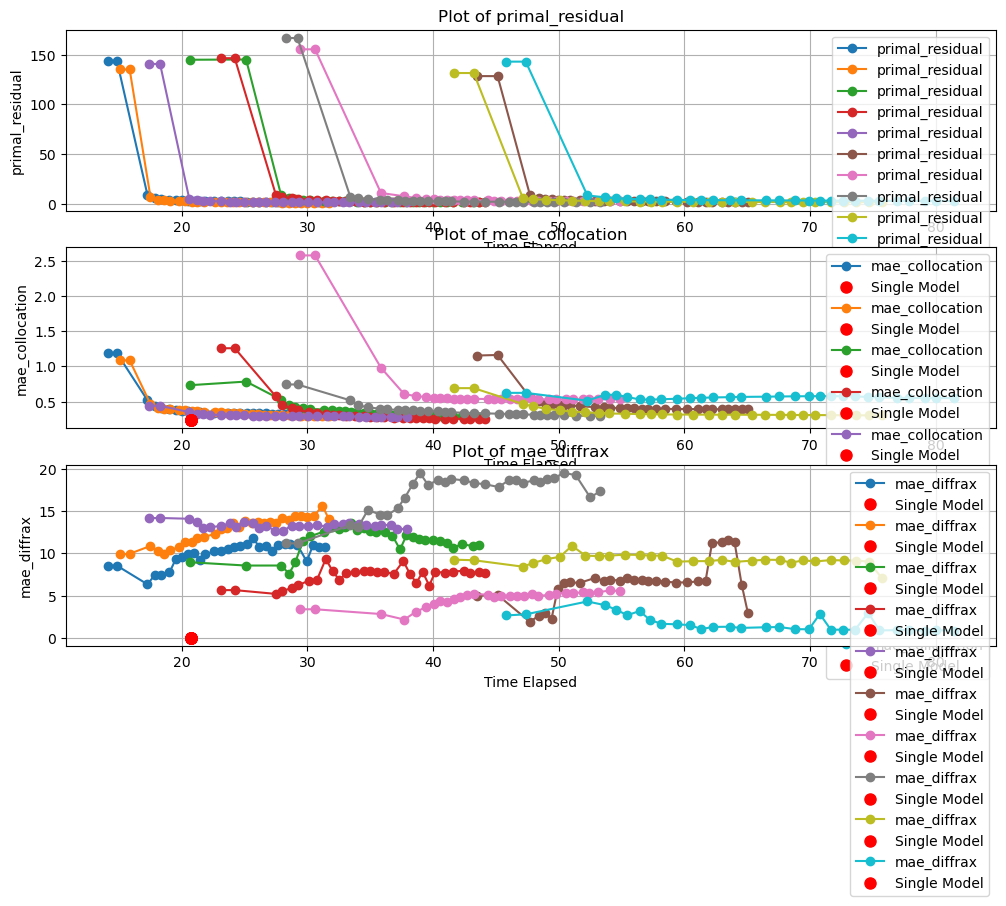

In [164]:
plt.figure(figsize=(12, 8))

columns = ['primal_residual', 'mae_collocation', 'mae_diffrax']

for date in results:
    pos = 0
    result = results[date]
    for key in result:
        if key != 'iter':
            
            if key not in columns:
                continue
            
            pos+=1
            plt.subplot(len(columns), 1, pos)
            plt.plot(result['time_elapsed'], result[key], label=key, marker='o')
            
            if key == 'mae_collocation':
                plt.plot(experiment_results['times_elapsed'], experiment_results['mae_coll_ode'], 
                        'o', color='r', label='Single Model', markersize=8)
            elif key == 'mae_diffrax':
                plt.plot(experiment_results['times_elapsed'], experiment_results['mae_odeint'], 
                        'o', color='r', label='Single Model', markersize=8)
            plt.title(f'Plot of {key}')
            plt.xlabel('Time Elapsed')
            plt.ylabel(key)
            plt.grid(True)
            plt.legend()

plt.tight_layout()
plt.show()

In [150]:
M = 150

tol = 1e-3
params = {"tol":tol, 
            "dual_inf_tol": tol, 
            "compl_inf_tol": tol,
            "constr_viol_tol": tol, 
            "acceptable_iter": 0,  
            "halt_on_ampl_error" : 'yes',
            "print_level": 5, 
            "max_iter": 100 }

initial_state, t, D, extra_input = ys[0][0], np.array(ts[:M]), D_1, np.array(Xs[M:])
y_solution_1 = ode_model.node_collocation_pred(initial_state, t, D, extra_input)

initial_state, t, D, extra_input = ys[M][0], np.array(ts[M:]), D_2, np.array(Xs[M:])
y_solution_2 = ode_model.node_collocation_pred(initial_state, t, D, extra_input)

Ipopt 3.14.16: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    11325

Total number of variables............................:      151
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      151
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number

In [151]:
initial_state, t, extra_input = jnp.array(ys[0]), jnp.array(ts[:M]), (jnp.array(Xs[:M]), jnp.array(ts[:M]))
y_sol_1_diffrax = ode_model.node_diffrax_pred(initial_state, t, extra_input)

initial_state, t, extra_input = jnp.array(ys[M]), jnp.array(ts[M:]), (jnp.array(Xs[M:]), jnp.array(ts[M:]))
y_sol_2_diffrax = ode_model.node_diffrax_pred(initial_state, t, extra_input)

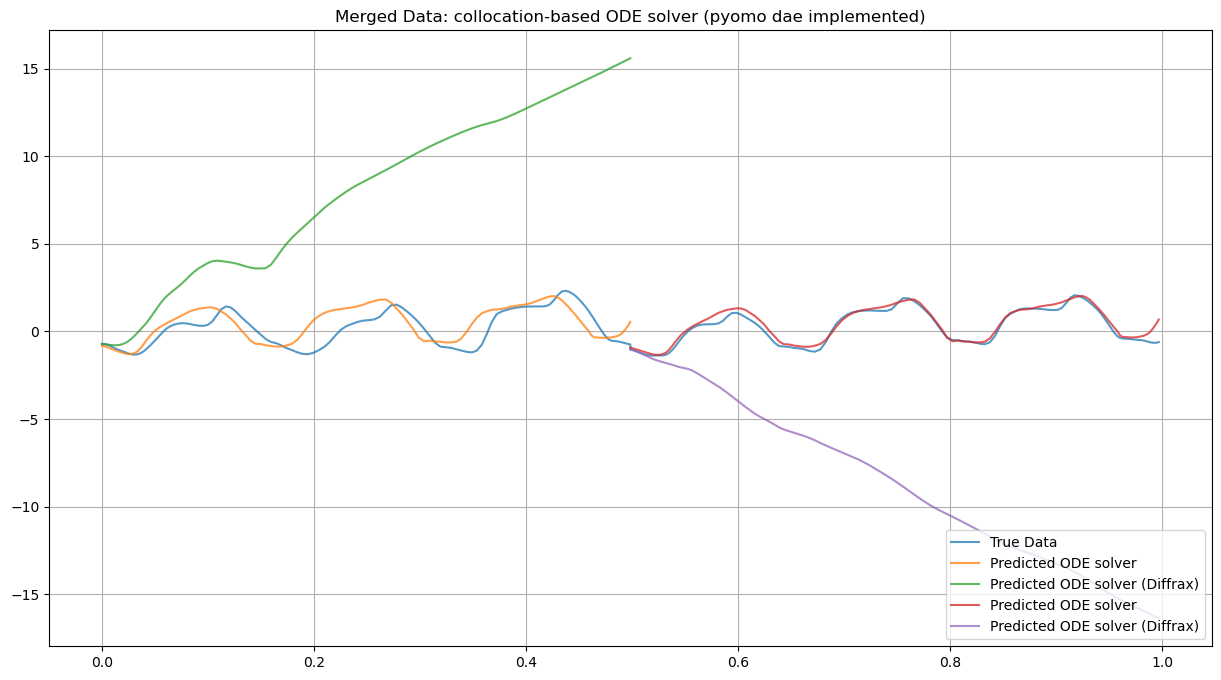

In [152]:
plt.figure(figsize=(15, 8))
plt.plot(ts, ys, label='True Data', alpha = 0.75)
plt.plot(ts[:M], y_solution_1, label='Predicted ODE solver', alpha = 0.75)
plt.plot(ts[:M], y_sol_1_diffrax, label='Predicted ODE solver (Diffrax)', alpha = 0.75)
plt.plot(ts[M:], y_solution_2, label='Predicted ODE solver', alpha = 0.75)
plt.plot(ts[M:], y_sol_2_diffrax, label='Predicted ODE solver (Diffrax)', alpha = 0.75)

plt.legend(loc ="lower right")
plt.grid(True)
plt.title("Merged Data: collocation-based ODE solver (pyomo dae implemented)")
plt.show()